In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [2]:
from sklearn.cluster import KMeans

In [3]:
df = pd.read_csv('OnlineRetail.csv', encoding= 'unicode_escape')
df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom


In [4]:
uk = df[df.Country == 'United Kingdom'].reset_index(drop=True)
uk.InvoiceDate = pd.to_datetime(uk.InvoiceDate)

In [5]:
uk_6m = uk[(uk.InvoiceDate >= '2011-3-1') & (uk.InvoiceDate < '2011-9-1')].reset_index(drop=True)
uk_next = uk[(uk.InvoiceDate >= '2011-9-1') & (uk.InvoiceDate < '2011-12-1')].reset_index(drop=True)

In [6]:
uk_user = pd.DataFrame(uk_6m['CustomerID'].unique(), columns=['CustomerID'])

In [7]:
#müşterinin gelecekte ilk satın alması
uk_next_first_purchase = uk_next.groupby('CustomerID').InvoiceDate.min().reset_index()
uk_next_first_purchase.columns = ['CustomerID','MinPurchaseDate']

In [8]:
#müşterinin 6m'de son satın alması
uk_last_purchase = uk_6m.groupby('CustomerID').InvoiceDate.max().reset_index()
uk_last_purchase.columns = ['CustomerID','MaxPurchaseDate']

In [9]:
uk_purchase_dates = pd.merge(uk_last_purchase, uk_next_first_purchase, on='CustomerID', how='left')

In [10]:
uk_purchase_dates['NextPurchaseDay'] = (uk_purchase_dates['MinPurchaseDate'] - uk_purchase_dates['MaxPurchaseDate']).dt.days
uk_purchase_dates.head(3)

,CustomerID,MaxPurchaseDate,MinPurchaseDate,NextPurchaseDay
0,12747.0,2011-08-22 10:38:00,2011-10-04 08:26:00,42.0
1,12748.0,2011-08-30 12:00:00,2011-09-02 10:49:00,2.0
2,12749.0,2011-08-18 06:19:00,2011-11-17 12:05:00,91.0


In [11]:
uk_user = pd.merge(uk_user, uk_purchase_dates[['CustomerID','NextPurchaseDay']], on='CustomerID', how='left')
uk_user = uk_user.fillna(999)
uk_user.head(3)

,CustomerID,NextPurchaseDay
0,14620.0,999.0
1,14740.0,999.0
2,13880.0,57.0


## Feature Engineering

#### RFM

In [12]:
#Recency için max satın alınan tarihler bulundu
uk_max_purchase = uk_6m.groupby('CustomerID').InvoiceDate.max().reset_index()
uk_max_purchase.columns = ['CustomerID','MaxPurchaseDate']

#Satır için max gün bulundu
uk_max_purchase['Recency'] = (uk_max_purchase['MaxPurchaseDate'].max() - uk_max_purchase['MaxPurchaseDate']).dt.days
uk_user = pd.merge(uk_user, uk_max_purchase[['CustomerID','Recency']], on='CustomerID')

#Cluster sıralaması
def order_cluster(cluster_field_name, target_field_name, df, ascending=False):
    df_idx = df.groupby(cluster_field_name)[target_field_name].mean().sort_values(ascending=ascending).reset_index()
    df_idx['index'] = df_idx.index
    df_last = pd.merge(df, df_idx[[cluster_field_name,'index']], on=cluster_field_name)
    df_last = df_last.drop([cluster_field_name], axis=1)
    df_last = df_last.rename(columns={'index':cluster_field_name})
    return df_last

#Recency
kmeans = KMeans(n_clusters=4).fit(uk_user[['Recency']])
uk_user['RecencyCluster'] = kmeans.predict(uk_user[['Recency']])
uk_user = order_cluster('RecencyCluster', 'Recency', uk_user, False)

#Frequency
uk_frequency = uk_6m.groupby('CustomerID').InvoiceDate.count().reset_index()
uk_frequency.columns = ['CustomerID','Frequency']

uk_user = pd.merge(uk_user, uk_frequency, on='CustomerID')

kmeans = KMeans(n_clusters=4).fit(uk_user[['Frequency']])
uk_user['FrequencyCluster'] = kmeans.predict(uk_user[['Frequency']])
uk_user = order_cluster('FrequencyCluster', 'Frequency', uk_user, True)

#Revenue - Monetary
uk_6m['Revenue'] = uk_6m['UnitPrice'] * uk_6m['Quantity']
uk_revenue = uk_6m.groupby('CustomerID').Revenue.sum().reset_index()
uk_revenue.columns = ['CustomerID','Revenue']

uk_user = pd.merge(uk_user, uk_revenue, on='CustomerID')

kmeans = KMeans(n_clusters=4).fit(uk_user[['Revenue']])
uk_user['RevenueCluster'] = kmeans.predict(uk_user[['Revenue']])
uk_user = order_cluster('RevenueCluster', 'Revenue', uk_user, True)

#Overall
uk_user['OverallScore'] = uk_user['RecencyCluster'] + uk_user['FrequencyCluster'] + uk_user['RevenueCluster']
uk_user.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()

uk_user['Segment'] = 'Low-Value'
uk_user.loc[uk_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
uk_user.loc[uk_user['OverallScore']>4,'Segment'] = 'High-Value'

#Plot
uk_graph = uk_user[(uk_user.Revenue < 50000) & (uk_user.Frequency < 2000)]

In [13]:
uk_user

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,14620.0,999.0,104,1,30,0,393.28,0,1,Low-Value
1,14740.0,999.0,91,1,93,0,1423.21,0,1,Low-Value
2,16462.0,111.0,85,1,2,0,68.00,0,1,Low-Value
3,15676.0,178.0,113,1,63,0,877.40,0,1,Low-Value
4,15092.0,999.0,115,1,26,0,457.81,0,1,Low-Value
...,...,...,...,...,...,...,...,...,...,...
2563,13089.0,0.0,0,3,895,2,22670.13,2,7,High-Value
2564,14298.0,23.0,23,3,750,2,23767.94,2,7,High-Value
2565,17841.0,3.0,3,3,3546,3,16643.22,2,8,High-Value
2566,18102.0,27.0,26,3,136,1,88948.33,3,7,High-Value


In [14]:
#Gün içi çoklu alım olabilir
uk_day_order = uk_6m[['CustomerID','InvoiceDate']]
uk_day_order['InvoiceDay'] = uk_6m['InvoiceDate'].dt.date
uk_day_order = uk_day_order.sort_values(['CustomerID','InvoiceDate'])
uk_day_order = uk_day_order.drop_duplicates(subset=['CustomerID','InvoiceDay'])

In [15]:
uk_day_order.head(3)

,CustomerID,InvoiceDate,InvoiceDay
649,12747.0,2011-03-01 14:53:00,2011-03-01
65091,12747.0,2011-05-05 15:31:00,2011-05-05
90473,12747.0,2011-05-25 09:57:00,2011-05-25


In [16]:
#Son 3 satın almanın tarihi bulundu
uk_day_order['PrevInvoiceDate'] = uk_day_order.groupby('CustomerID')['InvoiceDay'].shift(1)
uk_day_order['T2InvoiceDate'] = uk_day_order.groupby('CustomerID')['InvoiceDay'].shift(2)
uk_day_order['T3InvoiceDate'] = uk_day_order.groupby('CustomerID')['InvoiceDay'].shift(3)

In [17]:
uk_day_order.head(3)

,CustomerID,InvoiceDate,InvoiceDay,PrevInvoiceDate,T2InvoiceDate,T3InvoiceDate
649,12747.0,2011-03-01 14:53:00,2011-03-01,NaN,NaN,NaN
65091,12747.0,2011-05-05 15:31:00,2011-05-05,2011-03-01,NaN,NaN
90473,12747.0,2011-05-25 09:57:00,2011-05-25,2011-05-05,2011-03-01,NaN


In [18]:
uk_day_order['DayDiff'] = (uk_day_order['InvoiceDay'] - uk_day_order['PrevInvoiceDate']).dt.days
uk_day_order['DayDiff2'] = (uk_day_order['InvoiceDay'] - uk_day_order['T2InvoiceDate']).dt.days
uk_day_order['DayDiff3'] = (uk_day_order['InvoiceDay'] - uk_day_order['T3InvoiceDate']).dt.days

In [19]:
uk_day_order.head(3)

,CustomerID,InvoiceDate,InvoiceDay,PrevInvoiceDate,T2InvoiceDate,T3InvoiceDate,DayDiff,DayDiff2,DayDiff3
649,12747.0,2011-03-01 14:53:00,2011-03-01,NaN,NaN,NaN,NaN,NaN,NaN
65091,12747.0,2011-05-05 15:31:00,2011-05-05,2011-03-01,NaN,NaN,65.0,NaN,NaN
90473,12747.0,2011-05-25 09:57:00,2011-05-25,2011-05-05,2011-03-01,NaN,20.0,85.0,NaN


In [20]:
uk_day_diff = uk_day_order.groupby('CustomerID').agg({'DayDiff': ['mean','std']}).reset_index()
uk_day_diff.columns = ['CustomerID', 'DayDiffMean','DayDiffStd']

In [21]:
uk_day_diff.head(3)

,CustomerID,DayDiffMean,DayDiffStd
0,12747.0,43.500000,20.305993
1,12748.0,3.723404,3.083632
2,12749.0,25.000000,30.099834


In [22]:
#En az 3 alışverişi olan müşteriler için uygulandı
uk_day_order_last = uk_day_order.drop_duplicates(subset=['CustomerID'], keep='last')

In [23]:
uk_day_order_last = uk_day_order_last.dropna()
uk_day_order_last = pd.merge(uk_day_order_last, uk_day_diff, on='CustomerID')
uk_user = pd.merge(uk_user, uk_day_order_last[['CustomerID','DayDiff','DayDiff2','DayDiff3','DayDiffMean','DayDiffStd']], on='CustomerID')
#Dummies
uk_class = pd.DataFrame()
uk_class = uk_user.copy()
uk_class = pd.get_dummies(uk_class)

In [25]:
uk_class.head(3)

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,DayDiff,DayDiff2,DayDiff3,DayDiffMean,DayDiffStd,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value
0,14740.0,999.0,91,1,93,0,1423.21,0,1,6.0,34.0,92.0,30.666667,26.102363,0,1,0
1,17770.0,999.0,98,1,38,0,1143.27,0,1,14.0,77.0,84.0,28.000000,30.512293,0,1,0
2,15643.0,999.0,79,1,36,0,647.40,0,1,5.0,6.0,12.0,25.750000,43.553607,0,1,0


## Model

In [26]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier

In [27]:
uk_user.NextPurchaseDay.describe()

count    623.000000
mean     176.390048
std      326.482713
min        0.000000
25%       24.500000
50%       47.000000
75%       87.000000
max      999.000000
Name: NextPurchaseDay, dtype: float64

In [28]:
uk_class['NextPurchaseDayRange'] = 2
uk_class.loc[uk_class.NextPurchaseDay > 20, 'NextPurchaseDayRange'] = 1
uk_class.loc[uk_class.NextPurchaseDay > 50, 'NextPurchaseDayRange'] = 0

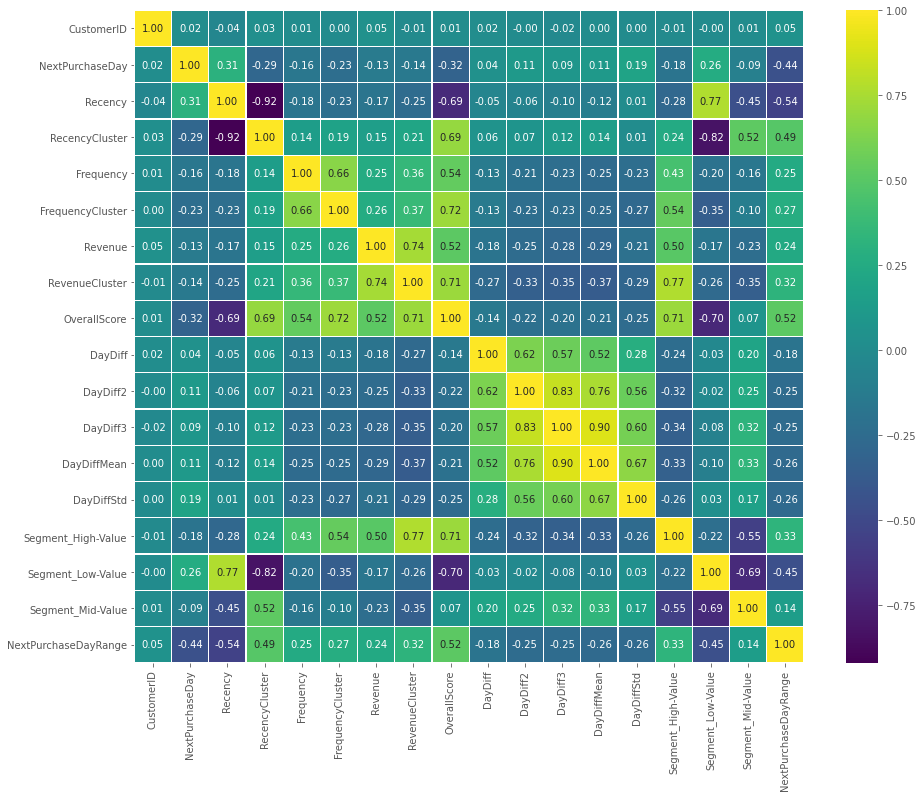

In [29]:
plt.figure(figsize = (15,12))
sns.heatmap(uk_class.corr(), annot = True, linewidths = 0.2, fmt=".2f", cmap='viridis');

In [30]:
uk_class = uk_class.drop('NextPurchaseDay', axis=1)
X, y = uk_class.drop('NextPurchaseDayRange',axis=1), uk_class.NextPurchaseDayRange
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
models = []
models.append(("logistic",LogisticRegression()))
models.append(("naive",GaussianNB()))
models.append(("random",RandomForestClassifier()))
models.append(("svc",SVC()))
models.append(("tree",DecisionTreeClassifier()))
models.append(("light",LGBMClassifier()))
models.append(("knn",KNeighborsClassifier()))

In [32]:
for name, model in models:
    kfold = KFold(n_splits=3, random_state=42)
    cv_result = cross_val_score(model, x_train, y_train, cv = kfold, scoring = 'accuracy').mean()
    print(name, cv_result)

logistic 0.5983935742971888
naive 0.5923694779116465
random 0.5983935742971888
svc 0.4979919678714859
tree 0.5582329317269077
light 0.6024096385542168
knn 0.48995983935742976


#### Parametreler

In [33]:
params = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gridcv_results = GridSearchCV(estimator = LGBMClassifier(), param_grid = params, scoring='accuracy',n_jobs=-1,iid=False, cv=2)
gridcv_results.fit(x_train, y_train)
gridcv_results.best_params_, gridcv_results.best_score_

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


({'max_depth': 5, 'min_child_weight': 5}, 0.606425702811245)

In [34]:
light_model = LGBMClassifier(max_depth=5, min_child_weight=5).fit(x_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(light_model.score(x_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(light_model.score(x_test[x_train.columns], y_test)))

Accuracy of XGB classifier on training set: 0.99
Accuracy of XGB classifier on test set: 0.62


In [155]:
y_pred = light_model.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.83      0.75        60
           1       0.51      0.45      0.48        40
           2       0.65      0.44      0.52        25

    accuracy                           0.63       125
   macro avg       0.62      0.57      0.59       125
weighted avg       0.62      0.63      0.62       125

